# Required Libraries

There are quite a few libraries and toolkits in Python that provide implementations of various algorithms that you can use to build a recommender.

For this particular exercise, I am going to use [Surprise](https://github.com/NicolasHug/Surprise).Surprise is a Python SciKit that comes with various recommender algorithms and similarity metrics to make it easy to build and analyze recommenders.

**Note:** If for any reason you prefer to use another library that you are more familiar with or you want to explore, feel free!

Here’s how to install it using pip (more info about the installation on the [Surprise documentation](http://surpriselib.com/)):

In [ ]:
! pip install numpy # Numpy is required by surprise
! pip install scikit-surprise

# MovieLens 100K

We’ll be working with the well known [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/). This dataset is the smaller version of the MovieLense movie recommendation dataset, a de-facto standard for the evaluation of recommendation systems.

The dataset includes 100K user ratings about a collection of movies. While this is not the most advanced, neither the most realistic recommendation dataset, it has been masively used for experimentation, what gives you the opportunity to compare your system with the literature of recommender systems.

Additionally, this is a nice starting point to familiarize with the recommendation problem.

# Read Data

Please, download the dataset from the following [link](http://files.grouplens.org/datasets/movielens/ml-100k.zip) and unzip it.

The dataset provides different files (you can check the README for more information), but we are only interested in the u.data (ratings) and the u.item (description of the movies for a more readable list of results).

In [1]:
import pandas as pd

# Please ensure to update the filepath to where you have unizipped it.
ratings = pd.read_csv('ml-100k/u.data', sep='\t', error_bad_lines=False, encoding="latin-1", header=None)
ratings.columns = ['userID', 'itemID', 'rating', 'timestamp']

# Please ensure to update the filepath to where you have unizipped it.
movies = pd.read_csv('ml-100k/u.item', sep='|', error_bad_lines=False, encoding="latin-1", header=None)[[0,1]]
movies.columns = ['itemID', 'title']

# Merge both datasets together to facilitate their use
df = pd.merge(ratings, movies, on='itemID', how='inner')[['userID','title','rating']]

Let's quickly visualize the dataset to ensure that everything looks good

In [2]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::20000, :])

Dataset shape: (100000, 3)
-Dataset examples-
       userID                         title  rating
0         196                  Kolya (1996)       3
20000     610  2001: A Space Odyssey (1968)       3
40000     592                Kingpin (1996)       5
60000     435               Supercop (1992)       3
80000      87         Batman & Robin (1997)       4


# Analyze the data

Before starting to work with the data I would like to take a quick view at it. I strongly encourage you to always perform this step to be sure that the data that you have makes sense, that you do not have any format problem or error you need to correct and to perform a first analysis to understand if the data you have will be enought to create a recommender system (or to go for a simpler approach).

This step is highly speculative and it's mainly based on your expertise, but there are some things in which we can focus

### Ratings distribution

The first thing is to analyze the distribution of ratings to understand among other things:

- The rating scale: is it 0-5, 1-5, 1-10....
- The distribution of the ratings: are the users biased to high or low rates?
- Are the users using the entire rating scale? e.g.: sometimes people performs binary ratings even if you provide them with a more granular scale (5 good, 1 bad and nothing in between)

**Note:** Don't be scared by the following code. Basically, I am counting the number of times each rating occurs in the dataset and plot the data in a fancy plotly histogram that you can interact with. If you are not very well versed in Python, you can just perform the counting an print the results

In [3]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Count the number of times each rating appears in the dataset
data = df['rating'].value_counts().sort_index(ascending=False)

# Create the histogram
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that ratings are biased to positive score. This tends to be common in many recommendation scenarios (for example in Google Reviews a restaurant with a scoring smaller than 4/3.5 if definitely a no-go). That's because we have the bias terms in the recommendation algorithms (later on we will see them in practice)

### Numbers of ratings per movie

The following analysis checks how many ratings (interactions) each movie has. As explained in class, due to the long tail "problem", we will have a tiny amount of highly popular movies (with many ratings) and a very large number of almost unknown movies (with a handful of ratings).

The degree in which this long tail phenomena occurs will be related to aspects such as serendipity or overespecialization of the recommendations and the recommendation methodology that you should select (i.e., if you only have ratings for a bunch of movies, perhaps it does not make sense to use a CF recommendation system)

In [4]:
# Number of ratings per movie
data = df.groupby('title')['rating'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Most of the movies received less than 10 ratings, and very few have many ratings. As discussed in class, this is very typical (and in fact one of the main problems) of Recommender Systems.

**Note:** This effect is even smaller in the MovieLens dataset since it is an experimental dataset that has been curated for it (i.e., from the documentation: "Each user has rated at least 20 movies").


### Number of ratings per user

Now it's time to see how many ratings we have per user. As previously noted, because of how the dataset was created, the minimum number of ratings per user in this dataset is 20, which alleviates the long-tail problem (i.e., when most of your users has very few or 0 ratings). 

Since this is an experimental dataset for research, they have created it this way. However, do not expect that in the real world. In fact, a common pre-processing step in recommendation is to remove those users/items for which you do not have many ratings and focus on the rest (at least for creating your model).

In [5]:
# Number of ratings per user
data = df.groupby('userID')['rating'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0, size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

As expected similar distribution

From this analysis, I do not see anything weird. I wasn't expected to see anything since, again, this is an experimental dataset, properly curated to avoid you any of the real-world problems. Nevertheless, it is always worthy to check, just in case. 

# Managing data with Surprise

It's now time to convert our datasets to the format required by the Surprise library. This step is pretty straightforward since the library provides some handy methods to do it (check them in the library documentation in case you want to know more).

To load a data set from the above pandas data frame, we will use the *load_from_df()* method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [6]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userID', 'title', 'rating']], reader)

# First Try: Neighbourhood-based Collaborative Filtering

We are going to start by using one of the simplest recommendation methodologies (Neighbourhood-based CF). This technique is pretty simple and fast, but it provides accurate results for many scenarios.

There are several Neighbourhood-based CF implementations in Surprise: https://surprise.readthedocs.io/en/stable/knn_inspired.html?highlight=neighbor. The choice of algorithm for the recommender function depends on the technique you want to use. For this first experiment, we are going to use the Baseline approach

To specify the parameters of the execution, you simply have to configure the function by passing a dictionary as an argument to the recommender function. The dictionary should have the required keys, such as the following:

- **name** contains the similarity metric to use. Options are cosine, msd, pearson, or pearson_baseline. The default is msd.
- **user_based** is a boolean that tells whether the approach will be user-based or item-based. The default is True, which means the user-based approach will be used.
- **min_support** is the minimum number of common items needed between users to consider them for similarity. For the item-based approach, this corresponds to the minimum number of common users for two items.
    
In particular, I will use the cosine distance as similarity metric for finding the neighbours, using the item-based approach

In [7]:
from surprise import KNNBaseline

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
knn = KNNBaseline(sim_options=sim_options)

Now that we have defined the algorithm configuration, we can actually test it. Again, Surprise provides some handy functions for it, in particular it includes a function to evaluate the algorithm via Cross Validation

In [8]:
from surprise.model_selection import cross_validate

results = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9460  0.9447  0.9509  0.9472  0.0027  
Fit time          2.28    1.99    2.65    2.31    0.27    
Test time         7.60    6.76    7.16    7.17    0.34    


The RMSE is about 0.95 (i.e., the average error between the predicted and the actual ratings). 

In order to actually understand the value of these results, my recommendation is to always comapare them to a very simple baseline approach implementing whatever logic or business rule you consider valid. For example: randomly recommend from the 10 most common books. 

The Surprise library implements different baseline methodologies (https://surprise.readthedocs.io/en/stable/basic_algorithms.html#). I am going to use the *NormalPredictor* recommendation that predicts a random rating based on the distribution of the training set, which is assumed to be normal.

In [9]:
from surprise import NormalPredictor

cross_validate(NormalPredictor(), data, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5188  1.5243  1.5269  1.5234  0.0034  
Fit time          0.11    0.12    0.12    0.12    0.01    
Test time         0.25    0.23    0.26    0.25    0.01    


{'test_rmse': array([1.51877873, 1.52434677, 1.52694327]),
 'fit_time': (0.10603952407836914, 0.11796331405639648, 0.12400484085083008),
 'test_time': (0.25350189208984375, 0.2265002727508545, 0.2579948902130127)}

RMSE is larger (as expected) what tells us that:
- KNN is actually learning from the training data
- 1.5 is the lower threshold for any recommender system in this dataset

## Tuning the Algorithm Parameters

As we explained, you can provide a dictionary with the desired configuration (i.e., similarity metric, user vs item based,...) to your recommendation algorithm. Ideally, you would like to test different configurations and select the one that best performs for your dataset and recommendation problem.

To that end, Surprise provides a GridSearchCV class analogous to GridSearchCV from scikit-learn.
With a dict of all parameters, GridSearchCV tries all the combinations of parameters and reports the best parameters for any accuracy measure

For example, you can check which similarity metric works best for your data in memory-based approaches:

In [10]:
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

The best configuration corresponds to a item-based configuration using Mean Square distance with a min support equals to 3, which is able to slightly reduce the RMSE to 0.942.


# Second Try: Matrix Factorization

Once we have understood the recommendation problem and how the Surprise library works, it's time to move to more interesting approaches, Matrix Factorization in particular.

Surprise provides different implementations of well-known matrix factorization methodologies: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

For this exercise, we are going to use SVD++ which usually offers state of the art results for many recommendation tasks

In [11]:
from surprise import SVDpp

# We'll use the famous SVD algorithm.
svd = SVDpp()

results = cross_validate(svd, data, measures=['RMSE'], cv=3, verbose=False)

As explained in class, matrix factorization methodologies usually offers a pretty good result and they are a good compromise between good performance and execution time, making them a great option for production systems.

# Third Try: Benchmarking

In the following exercise we are going to experiment with different algorithms to check which one of them offers the best results.



In [12]:
from surprise import SVD
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), BaselineOnly(), CoClustering()]:
    
    print("Testing {}".format(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Testing <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001C7E3BB4608>
Testing <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000001C7E8922548>
Testing <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000001C7E89220C8>
Testing <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000001C7E7052D48>
Testing <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001C7E50C4E88>
Testing <surprise.prediction_algorithms.knns.KNNBaseline object at 0x000001C7E89223C8>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Testing <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x000001C7E8922A48>
Estimating biases using als...

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.928070,141.543227,5.618849
KNNBaseline,0.934993,0.528169,6.393331
SVD,0.944073,4.917679,0.286320
BaselineOnly,0.947290,0.178017,0.188694
SlopeOne,0.949257,0.679832,4.530499
NMF,0.976964,4.522496,0.254670
CoClustering,0.977829,1.954331,0.211189
NormalPredictor,1.516653,0.111665,0.285518


As expected the best results are offered by matrix factorization, particularly SVD++. However, if we take a look at the fitting time we see that it takes a lot of time to train (especially compared to SVD). If training time is a blocker for your situation (e.g., you have to perform online retraining anytime a new data point appears) you should consider the simpler version of SVD.

Neighbourhood-based methods (KNN) also works pretty well for this dataset. My recommendation is that you always should try it. In spite of being such a simple approach, it is usually able to capture meaningful patterns. The downside of these approaches, as discussed in class is that they take a lot of time to offer predictions (since they perform most of the work during test time). If your recommendation scenario requires to offer recommendations in real time, perhaps KNN is not the most suitable approach.

Surprisingly, the BaselineOnly and approach is offering very competitive results in spite of its simplicity. When no complex recommendation patterns are involved (e.g., people usually like blockbusters), baseline approaches based on generic statistics use to perform well.

# Interpretation

In this final section I would like to provide you with some examples about how to interpret the results and execution of your recommendation system.

This interpretation is very useful to understand the operation of the recommendation system and to be able to improve their results, as well as to explain the recommendation to relevant stakeholders.

The code is a little bit tricky and it will be different if you use a different library (you should research about how to replicate this analysis with your preferred library), so don't get discouraged if you get lost in the Python Code and focus on iterpreting and understanding the results and to capture the idea.

## Get Neigbours

If you are using a neighbourd based methodology you can inspect the neighbourhoods in which the recommendations are generated. For example, you can take an item (or user) and analyze their neighbourhood to check if it makes sense (i.e., if it includes items or users similar to the one that you are analyzing).

The following code gets the 10 closest neighbours to a given movie.

In [13]:
# Execute KNN
sim_options = {'name': 'pearson_baseline', 'user_based': False}
knn = KNNBaseline(sim_options=sim_options)
knn.fit(data.build_full_trainset())

# Target movie to analyze its neighbourhood
movie_name = 'Toy Story (1995)'

# Get the closes neighbourds
neighbors = knn.get_neighbors(knn.trainset.to_inner_iid(movie_name), k=10)
# Translate the internal ids used in the algorithm to the movie names
neighbors = (knn.trainset.to_raw_iid(inner_id) for inner_id in neighbors)

print()
print('The 10 nearest neighbors of {} are:\n'.format(movie_name))
for movie in neighbors:
    print("\t",movie)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

The 10 nearest neighbors of Toy Story (1995) are:

	 Beauty and the Beast (1991)
	 Raiders of the Lost Ark (1981)
	 That Thing You Do! (1996)
	 Lion King, The (1994)
	 Craft, The (1996)
	 Liar Liar (1997)
	 Aladdin (1992)
	 Cool Hand Luke (1967)
	 Winnie the Pooh and the Blustery Day (1968)
	 Indiana Jones and the Last Crusade (1989)


Well, it seems that the Toy Story neighbourhood makes sense: it mostly includes other children's movies or movies that a kid/teenager might like.

## Check Factorized Matrices

If you are using a matrix factorization based algorithm, such as SVD, you can actually analyze the resulting matrices to understand what the algorithm is doing.

In particular, you can analyze 2 things:
- **Bias**: Bias terms try to consider the tendencies in the ratings to be biased to a particular aspect. For example, they are movies which score is consistently lower; therefore, no matter how much the algorithm thinks that someone could like the movie, it should consider that we are talking a really bad movie. In the same way, if a user is pretty exigent and usually rates all the movies with very low scores (even The Godfather), we should consider it when we are trying to predict how much is going to like the movie
- **Factors**: These are the underlying factors that are driving the ratings (e.g., I like blockbusters, I like children movies...) that we expect the matrix factorization algorithm to learn from the rating matrix.

### Analyze BIAS

Let's start analyzing the bias. Luckily for us, Surprise provides a "rather simple" way of accessing the bias terms

#### Item Bias

First we will analyze the bias related to the items to understand if there is any bias in their ratings. Ideally, it should be. We all know that there are movies that are "indisputably" good or bad, which should be reflected in the ratings (and consequently be captured by the matrix factorization method).

Let's see. What I will do is to plot the movies with a large negative (worst movies ever) and positive (best movies ever) bias.

In [18]:
movie_bias = [(b, data.build_full_trainset().to_raw_iid(i)) for i, b in enumerate(svd.bi)]
print("Worst movies ever:")
sorted(movie_bias, key=lambda x: x[0])[:15]

Worst movies ever:


[(-1.487444897341633, 'Dumbo (1941)'),
 (-1.4027757779187595, 'Beverly Hillbillies, The (1993)'),
 (-1.2743400186051685, 'Lightning Jack (1994)'),
 (-1.2033035900778157, 'Treasure of the Sierra Madre, The (1948)'),
 (-1.195564653624382, 'Barbarella (1968)'),
 (-1.1882911538562877, 'Ghost and Mrs. Muir, The (1947)'),
 (-1.1741534705285284, "City Slickers II: The Legend of Curly's Gold (1994)"),
 (-1.1680560366223394, 'How to Make an American Quilt (1995)'),
 (-1.1615205695897657, 'Mad Love (1995)'),
 (-1.1574289305227874, 'Apocalypse Now (1979)'),
 (-1.1233273182221486, 'Roommates (1995)'),
 (-1.1217279221265204, 'Primal Fear (1996)'),
 (-1.096857787537745, 'Tango Lesson, The (1997)'),
 (-1.089495779755183, 'Virtuosity (1995)'),
 (-1.0778390354641196, 'Original Gangstas (1996)')]

In [19]:
print("Worst movies ever:")
sorted(movie_bias, key=lambda x: -x[0])[:15]

Worst movies ever:


[(1.0211527685183819, 'Outbreak (1995)'),
 (0.9442002782703149, 'Interview with the Vampire (1994)'),
 (0.9421700253711203, 'Crossing Guard, The (1995)'),
 (0.8723334067200819, 'Smoke (1995)'),
 (0.8692777893664189, "Gridlock'd (1997)"),
 (0.8558686551457666, 'Escape to Witch Mountain (1975)'),
 (0.8462235249718529, 'Citizen Kane (1941)'),
 (0.8456512758611057, 'Mrs. Doubtfire (1993)'),
 (0.8400165682248344, 'Sabrina (1995)'),
 (0.8353161516417555, 'Akira (1988)'),
 (0.8350900924576887, 'Stalingrad (1993)'),
 (0.8039597952772438, 'Dracula: Dead and Loving It (1995)'),
 (0.7962061588378314, 'Pallbearer, The (1996)'),
 (0.7895264412136918, 'Hear My Song (1991)'),
 (0.7796911469477453, 'Stag (1997)')]

Since the topic could be a little controversial, I will let you decide how accurate are the biases.

#### User Bias

We can perform the same bias analysis over the users. The idea is the following: there are people that consistently rate movies very well or very badly, no matter the movie quality.

Let's see if that happens in our dataset and if the algorithm is able to capture it

The following code prints the user with the most negative bias

In [20]:
user_bias = [(b, data.build_full_trainset().to_raw_uid(i)) for i, b in enumerate(svd.bu)]
sorted(user_bias, key=lambda x: x[0])[0]

(-1.7877768749264766, 102)

If we check their scores, we see that they are pretty bad.

In [21]:
df[df.userID == 181]

,userID,title,rating
44,181,Kolya (1996),1
127,181,L.A. Confidential (1997),2
2067,181,Star Trek: First Contact (1996),4
2607,181,Sabrina (1995),4
3187,181,Twister (1996),2
...,...,...,...
99942,181,Ed's Next Move (1996),1
99966,181,JLG/JLG - autoportrait de décembre (1994),1
99979,181,August (1996),1
99981,181,Hedd Wyn (1992),1


In contrast, if we analyze the user with the most positive bias, we will see that they scores are pretty high.

In [22]:
sorted(user_bias, key=lambda x: x[0])[-1]

(1.2532925260988244, 583)

In [23]:
df[df.userID == 688]

,userID,title,rating
363,688,L.A. Confidential (1997),5
6314,688,Fly Away Home (1996),5
7134,688,Kiss the Girls (1997),5
10059,688,Scream (1996),5
13539,688,Bean (1997),5
17900,688,"Devil's Advocate, The (1997)",4
32075,688,Mad City (1997),5
37413,688,"MatchMaker, The (1997)",5
40171,688,"Peacemaker, The (1997)",5
40839,688,Volcano (1997),5


### Analyze Factors

Finally we can analyze the factors. This step is way more complex. Factors are not easily interpretable even for a small dataset an a small number of them (i.e., by default the SVD implementation in Surprise uses 20 factors).

You can try to plot the factor matrix and review it cell by cell trying to find some correlation and how it is related to the users and the movies, but I strongly recommend you not to do it.

In [24]:
svd.qi

array([[-2.87590292e-01, -6.48678098e-01,  2.85514522e-01, ...,
         3.29709156e-01, -9.14400134e-02, -1.73895244e-01],
       [-3.41813832e-01, -9.24127677e-02, -1.08097623e-01, ...,
         2.23559299e-01,  9.75087353e-02, -7.79958648e-02],
       [ 5.02009340e-04, -3.63289091e-01, -8.87284399e-02, ...,
         1.25435826e-01, -2.64966283e-02, -1.15664441e-01],
       ...,
       [ 1.91885411e-01, -1.26584992e-01,  1.57517506e-01, ...,
        -1.32503743e-01, -1.03553911e-02, -3.74030719e-02],
       [ 2.22918884e-01,  8.66114740e-02, -6.62251062e-02, ...,
        -4.79792985e-02, -1.04814201e-03,  9.20735458e-02],
       [ 5.21467084e-02,  4.21591254e-02, -2.35594031e-02, ...,
        -8.87121368e-02, -2.53910454e-02,  6.29776063e-02]])

What we can do is to try to reduce the factors, focus on the most important ones and try to understand if they make any sense.

A common way of doing it is to apply PCA to reduce the dimensionality of the factor matrix to a number that we can analyze and to check if there is any pattern that make sense for us. If we discover these patterns is because the original factorized matrix was able to capture meaningfull factors that can be exploited for recommendation.

I am going to apply PCA to find the 3 principal components of the factorized matrix

In [25]:

from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(svd.qi)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

Now we can plot the movies related to each one of the Principal Components and check if there is any pattern that makes sense for us

In [26]:
for row in principalDf.sort_values(by='principal component 1', ascending=False).head(10).iterrows():
    print("Movie: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][0]))
    

Movie: Batman Forever (1995) with PC value = 7.127224045811679
Movie: As Good As It Gets (1997) with PC value = 6.497862692475638
Movie: Casablanca (1942) with PC value = 5.921647194569985
Movie: Crying Game, The (1992) with PC value = 5.858523876430597
Movie: Mediterraneo (1991) with PC value = 5.540002135299654
Movie: Independence Day (ID4) (1996) with PC value = 5.289315644521826
Movie: Boot, Das (1981) with PC value = 5.11961225018138
Movie: Body Snatcher, The (1945) with PC value = 4.958080781221413
Movie: Hackers (1995) with PC value = 4.80916041424479
Movie: Things to Do in Denver when You're Dead (1995) with PC value = 4.7640427894898165


In [27]:
for row in principalDf.sort_values(by='principal component 2', ascending=False).head(10).iterrows():
    print("Movie: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][1]))

Movie: Chungking Express (1994) with PC value = 6.361514094499045
Movie: Sling Blade (1996) with PC value = 6.242174734922096
Movie: Terminator, The (1984) with PC value = 6.125925732838591
Movie: Welcome to the Dollhouse (1995) with PC value = 5.750174436661971
Movie: Heavy Metal (1981) with PC value = 5.543653754816361
Movie: Raging Bull (1980) with PC value = 5.527394549671999
Movie: Contact (1997) with PC value = 5.320291230338105
Movie: Picnic (1955) with PC value = 5.304375815989779
Movie: Close Shave, A (1995) with PC value = 5.264635500792049
Movie: Renaissance Man (1994) with PC value = 5.119014002553325


In [28]:
for row in principalDf.sort_values(by='principal component 3', ascending=False).head(10).iterrows():
    print("Movie: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][2]))

Movie: Mediterraneo (1991) with PC value = 5.435716592608913
Movie: Oliver & Company (1988) with PC value = 5.40233991598455
Movie: Hollow Reed (1996) with PC value = 5.246155279790664
Movie: Lightning Jack (1994) with PC value = 4.639498443981389
Movie: Batman Forever (1995) with PC value = 4.4666575993675375
Movie: Seven Years in Tibet (1997) with PC value = 4.245977905285722
Movie: Sex, Lies, and Videotape (1989) with PC value = 4.186276785490852
Movie: Jane Eyre (1996) with PC value = 4.098436543448361
Movie: Charade (1963) with PC value = 4.08578026551942
Movie: Die Hard: With a Vengeance (1995) with PC value = 4.0542740094953915


It looks pretty good!

PC1 seems to be related to blockbusters, PC2 to sci-fi movies and PC3 to horror movies (i.e., the patterns are not perfect; for example, we see The Godfather among the sci-fi movies, but you need to understand that we are reducting the original 20 factors in the SVD factorized matrix to 3, so some of them are going to be mixed or affected).

For a more visual analysis, we can take the first 2 Principal Components and plot the movies according to them. We would expect to see similar movies together.

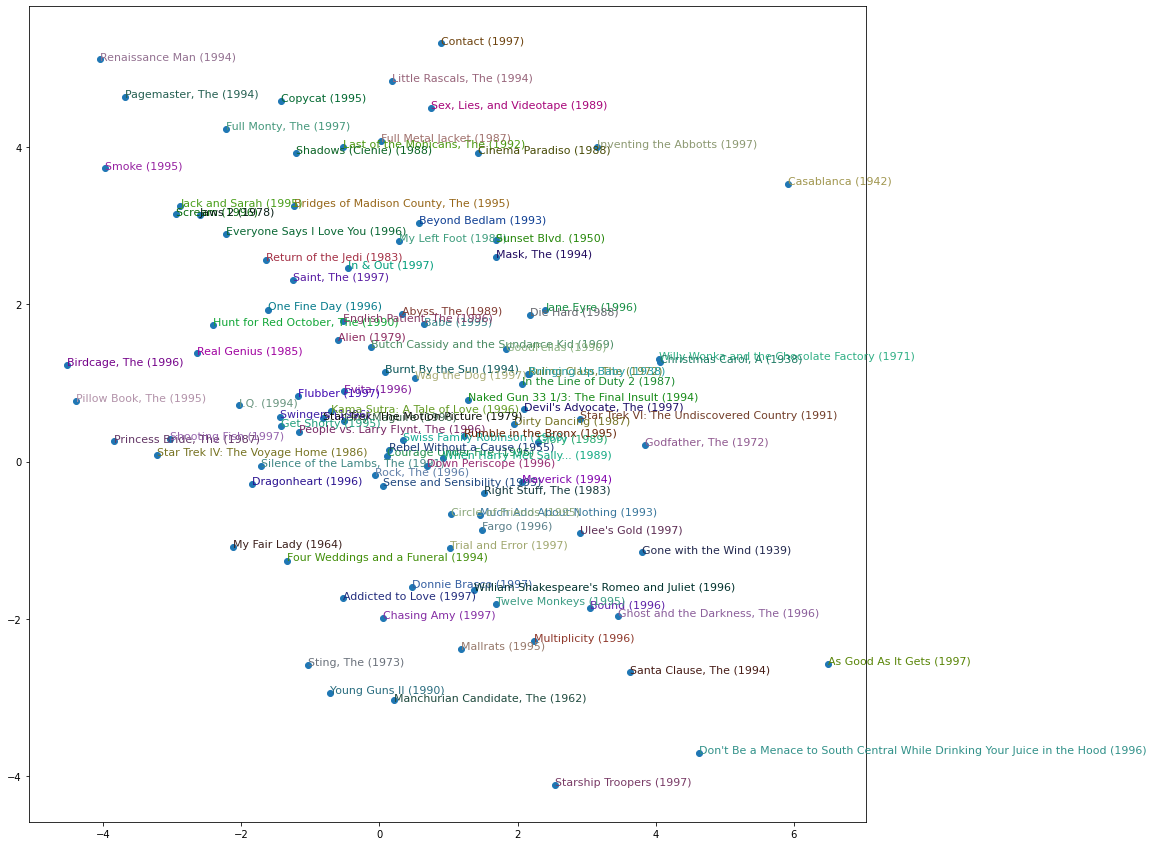

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Taking randomly just 100 movies to avoid overcrowding the plot
idxs = np.random.choice(len(principalDf), 100, replace=False) 
idxs = list(range(100))

# Represent the movies according to the principal components
X = principalDf.iloc[idxs]['principal component 1'].values
Y = principalDf.iloc[idxs]['principal component 2'].values

# Plot the movies
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip([trainset.to_raw_iid(idx) for idx in idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()